### Loading packages

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import Imputer # 사라짐
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

### Loading data

In [144]:
train = pd.read_csv('../PortoSeguro/train_reduce2.csv')
test = pd.read_csv('../PortoSeguro/test_reduce2.csv')

### Data at first sight

* Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).  
* Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.  
* Features without these designations are either continuous or ordinal.  
* Values of -1 indicate that the feature was missing from the observation.  
* The target columns signifies whether or not a claim was filed for that policy holder.   

* Binary features == 여부([0,1], [true, false])  
* Categorical(범주형) features   
  * 명목형 자료(Nominal data) == 성별(남/여), 혈액형(A/B/O/AB)  # 순서의 의미가 없다.
  * 순서형 자료(Ordinal data) == 효과(없음/조금있음/매우있음)   # 순서의 의미가 있다.
  
* Numerical(수치형) features  
  * 이산형 자료(Discrete data)   == 일정기간 동안의 발생횟수, 출산횟수  # 이산적인 값을 가짐 
  * 연속형 자료(Continuous data) == 신장, 체중, 협압                    # 연속적인 값을 가짐

### We indeed see the following ###   
* binary variables
* categorical variables of which the category values are integers
* other variables with integer or float values
* variables with -1 representing missing values
* the target variable and an ID variable

In [145]:
train.shape

(49999, 59)

In [146]:
test.shape

(49999, 58)

In [147]:
train.drop_duplicates()
train.shape

(49999, 59)

No duplicate rows, so that's fine

In [ ]:
train.info()

### Metadata ###  
To facilitate the data management, we'll store meta-information about the variables in a DataFrame.   
This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...


Concretely we will store:

* role: input, ID, target
* level: nominal, interval, ordinal, binary
* keep: True or False
* dtype: int, float, str

In [149]:
data = []
for f in train.columns:
    
    # Defining the role 
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
    
    # Initialize keep to True for all variables except for id 
    keep = True 
    if f == 'id':
        keep = False
    
    # Defining the data type
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable 
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [ ]:
meta

In [ ]:
meta[(meta.level == 'nominal') & (meta.keep)].index

In [150]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


### Descriptive Statistics

#### Interval variables

In [54]:
v = meta[(meta.level == 'interval') & (meta.keep)].index

In [55]:
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,0.611744,0.428359,0.539683,0.378948,0.811761,0.280150,3.064025,0.458564,0.454154,0.456359
std,0.285012,0.386391,0.791087,0.061781,0.236304,0.350502,0.739527,0.292116,0.285462,0.288444
min,0.000000,0.000000,-1.000000,0.315278,0.339968,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.521416,0.316228,0.670928,0.337639,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.709753,0.374166,0.759220,0.368782,3.316625,0.500000,0.500000,0.500000
75%,0.900000,0.600000,0.982662,0.400000,0.897062,0.394335,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,2.332649,1.264911,2.707275,0.565685,3.741657,0.900000,0.900000,0.900000


##### reg variables  

* only ps_reg_03 has missing values
* the range (min to max) differs between the variables. We could appy scaling   
  (e.g. StandardScaler), but it depends on the classifier we will want to use.

##### car variables  
* ps_car_12 and ps_car_15 have missing values  
* again, the range differs and we could apply scaling.  

##### calc variables  
* no missing values  
* this seems to be some kind of ratio as the maximum is 0.9
* all three_calc variables have very similar distributions  

**Overal**, we can see that the range of the interval variables is rather small.   
Perhaps some transformation (e.g. log) is already applied in order to anonymizae the data?

#### Ordinal variables

In [59]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,1.822564,4.354359,0.010769,7.256410,2.368205,2.368718,1.895385,7.760513,3.002051,9.233846,2.346154,8.373333,5.393846,1.486154,2.852308,7.680000
std,1.918371,2.705688,0.112743,3.553577,0.816589,1.132543,1.143536,1.311660,1.429728,1.445675,1.240944,2.871653,2.344773,1.202257,1.648337,2.805689
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,10.000000
max,7.000000,11.000000,2.000000,13.000000,3.000000,5.000000,6.000000,10.000000,8.000000,12.000000,6.000000,18.000000,14.000000,7.000000,10.000000,17.000000


#### Binary variables

In [60]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,1950.000000,1950.00000,1950.000000,1950.000000,1950.000000,1950.0,1950.000000,1950.000000,1950.0,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,0.037949,0.41641,0.251282,0.146667,0.185641,0.0,0.002051,0.008718,0.0,0.666154,0.114872,0.156410,0.124615,0.614872,0.566667,0.292308,0.357436,0.153846
std,0.191121,0.49309,0.433862,0.353864,0.388916,0.0,0.045256,0.092986,0.0,0.471706,0.318949,0.363337,0.330367,0.486750,0.495663,0.454940,0.479368,0.360894
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.00000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* A priori in the train data is 3.645%, which is **strongly imbalanced.**
* From the means we can conclude that for most variables the value is zero in most cases.

### Handling imbalanced classes

* oversampling records with target=1  
* undersampling records with target=0  
  

**과소표집(UnderSampling)**  
* 다른 클래스에 비해 상대적으로 많이 나타나있는 클래스의 개수를 줄이는 것 
* 이를 통해 균형을 유지할 수 있게 되지만, 제거하는 과정에서 유용한 정보가 버려지게 되는 큰 단점  

**과대표집(OverSampling)**  
* 데이터를 복제하는 것
* 정보를 잃지 않고, 훈련용 데이터에서 높은 성능을 보이지만 실험용 데이터에서의 성능은 낮아 질 수 있다. 

In [151]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.3425030104222896
Number of records with target=0 after undersampling: 16497


### Data Quality Checks

**Checking missing values**  
Missings are represented as -1

In [152]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings / train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 9 records (0.05%) with missing values
Variable ps_ind_04_cat has 4 records (0.02%) with missing values
Variable ps_ind_05_cat has 182 records (0.99%) with missing values
Variable ps_reg_03 has 3271 records (17.85%) with missing values
Variable ps_car_01_cat has 4 records (0.02%) with missing values
Variable ps_car_03_cat has 12473 records (68.05%) with missing values
Variable ps_car_05_cat has 8073 records (44.04%) with missing values
Variable ps_car_07_cat has 349 records (1.90%) with missing values
Variable ps_car_09_cat has 20 records (0.11%) with missing values
Variable ps_car_14 has 1313 records (7.16%) with missing values
In total, there are 10 variables with missing values


- **ps_car_03_cat and ps_car_05_cat** have a large proportion of records with missing values. Remove these variables.  
- For the other categorical variables with missing values, we can leave the missing value -1 as such.  
- **ps_reg_03** (continuous) has missing values for 18% of all records. Replace by the mean.  
- **ps_car_11** (ordinal) has only 5 records with misisng values. Replace by the mode.  
- **ps_car_12** (continuous) has only 1 records with missing value. Replace by the mean.  
- **ps_car_14** (continuous) has missing values for 7% of all records. Replace by the mean.  

In [153]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace = True, axis = 1)
meta.loc[(vars_to_drop), 'keep'] = False  # Updating the meta

In [154]:
# Imputing with the mean or mode 
# 누락값 대체 (mean, median, most_frequent)
mean_imp = SimpleImputer(missing_values = -1, strategy = 'mean')           # 평균 (디폴트)
mode_imp = SimpleImputer(missing_values = -1, strategy = 'most_frequent')  #  최빈값 

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

In [155]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings / train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 9 records (0.05%) with missing values
Variable ps_ind_04_cat has 4 records (0.02%) with missing values
Variable ps_ind_05_cat has 182 records (0.99%) with missing values
Variable ps_car_01_cat has 4 records (0.02%) with missing values
Variable ps_car_07_cat has 349 records (1.90%) with missing values
Variable ps_car_09_cat has 20 records (0.11%) with missing values
In total, there are 6 variables with missing values


#### Checking the cardinality of the categorical variables  
Cardinality refers to the number of different values in a variable.   
A we will create dummy variables from the categorical variables later on,  
we need to check whether there are variables with many distinct values.   
We should handle these variables differently as they would result in many dummy variables.

In [156]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


Only **ps_car_11_cat** has many distinct values, although it is still reasonable.

In [157]:
# Script by https://www.kaggle.com/ogrellier  
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features  
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior 
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [158]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"],
                              test["ps_car_11_cat"],
                              target = train.target,
                              min_samples_leaf = 100,
                              smoothing = 10,
                              noise_level = 0.01)
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis = 1, inplace = True)
meta.loc['ps_car_11_cat', 'keep'] = False # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace = True)

### Exploratory Data Visualization

**Categorical variables**  
Let's look into the categorical variables and the proportion of customers with target = 1

<Figure size 432x288 with 0 Axes>

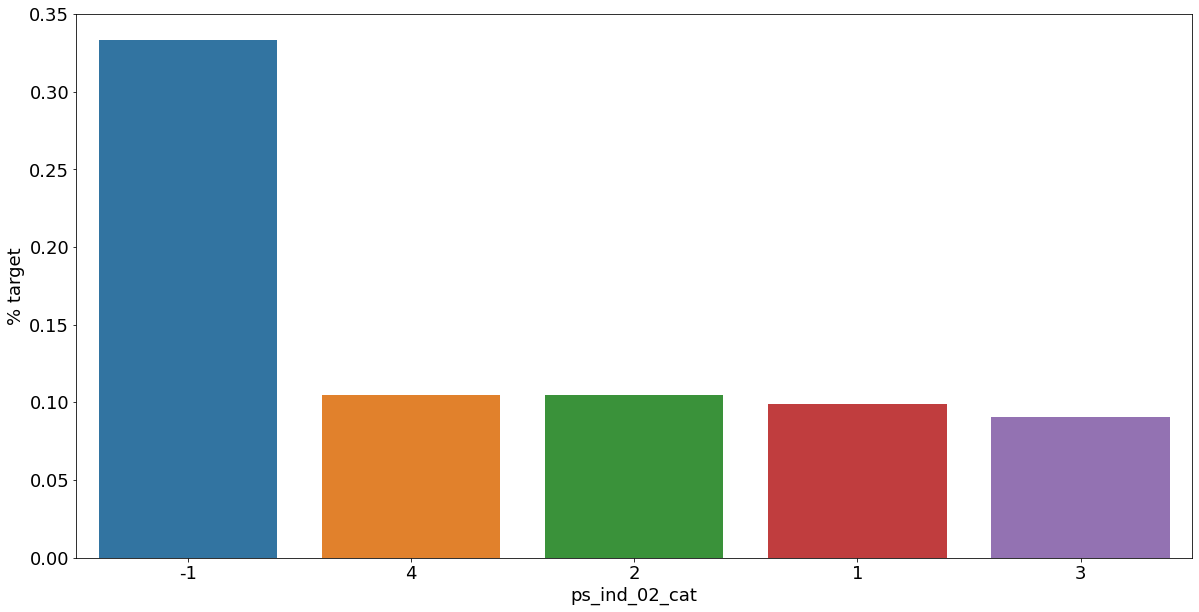

<Figure size 432x288 with 0 Axes>

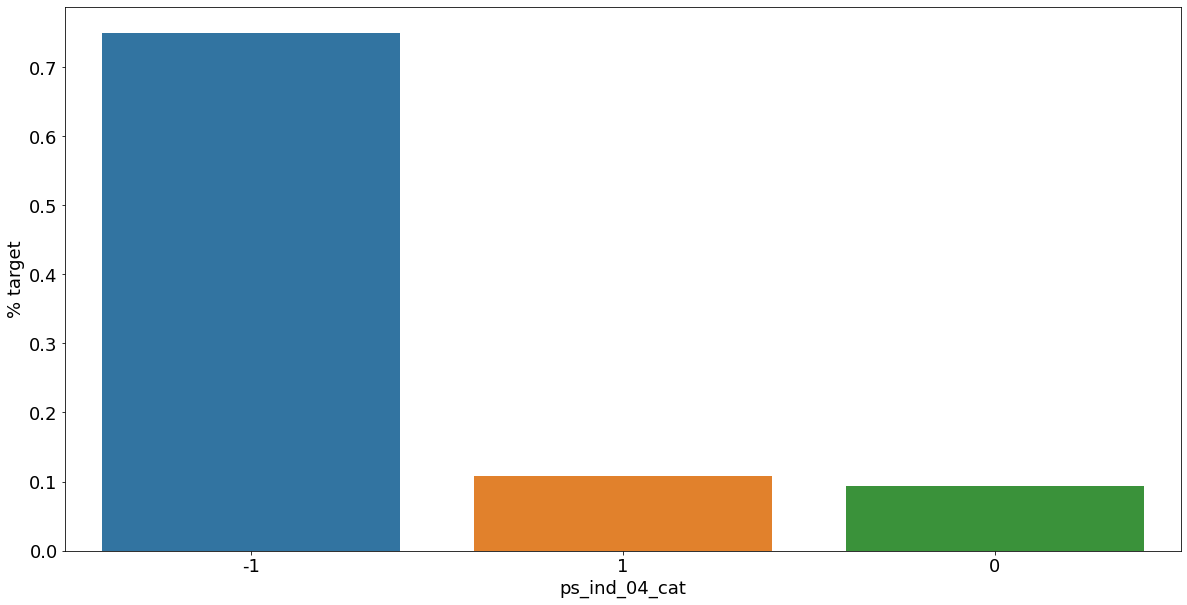

<Figure size 432x288 with 0 Axes>

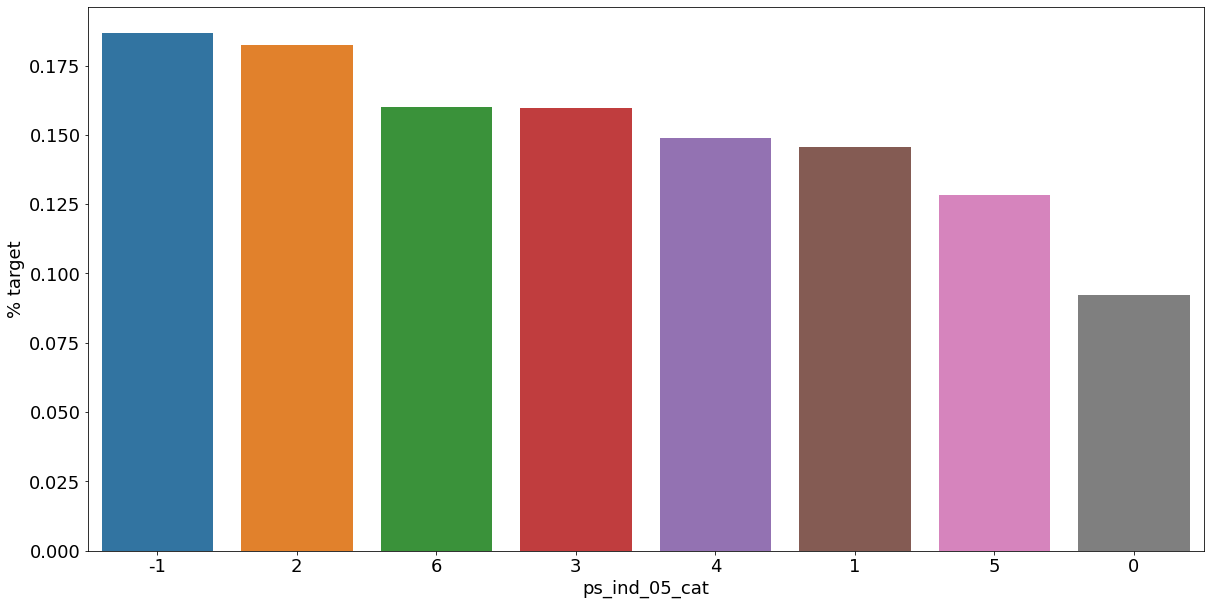

<Figure size 432x288 with 0 Axes>

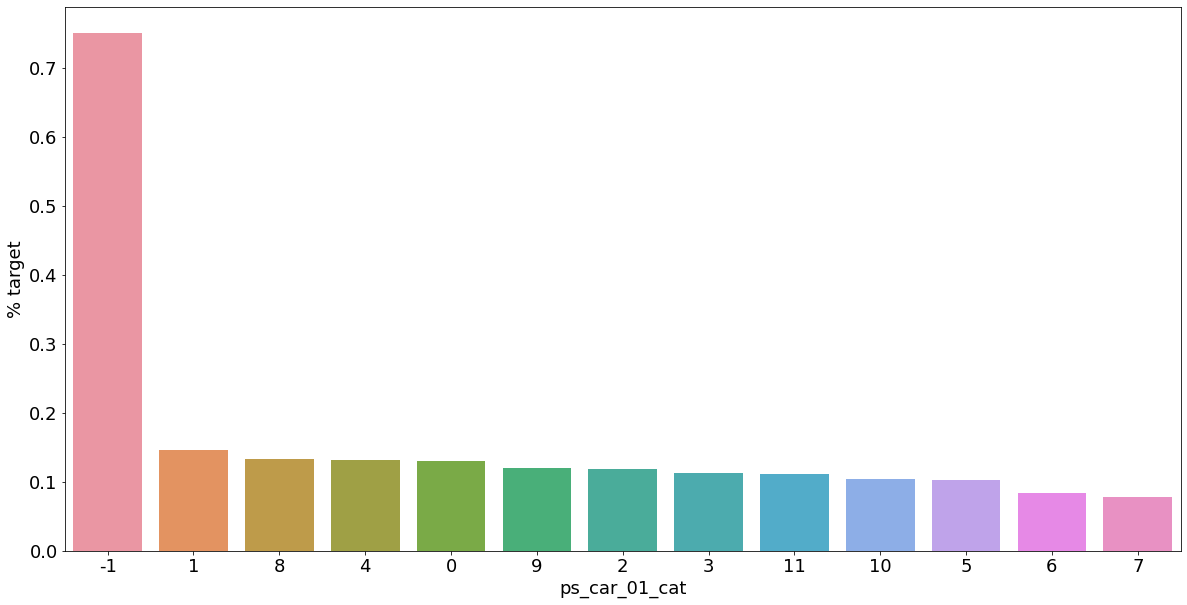

<Figure size 432x288 with 0 Axes>

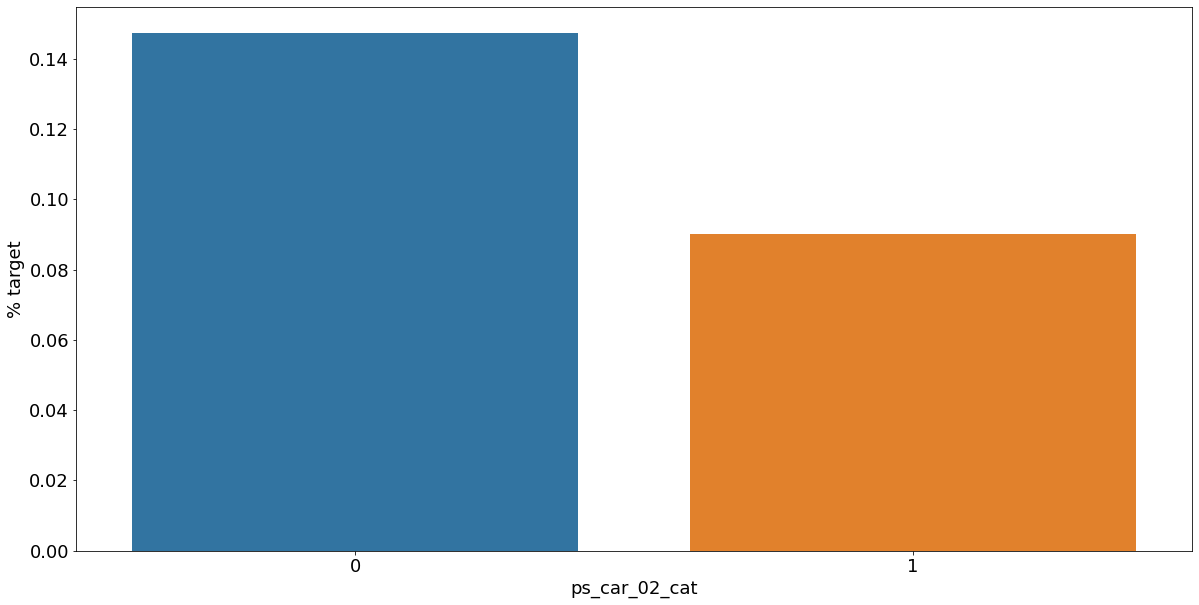

<Figure size 432x288 with 0 Axes>

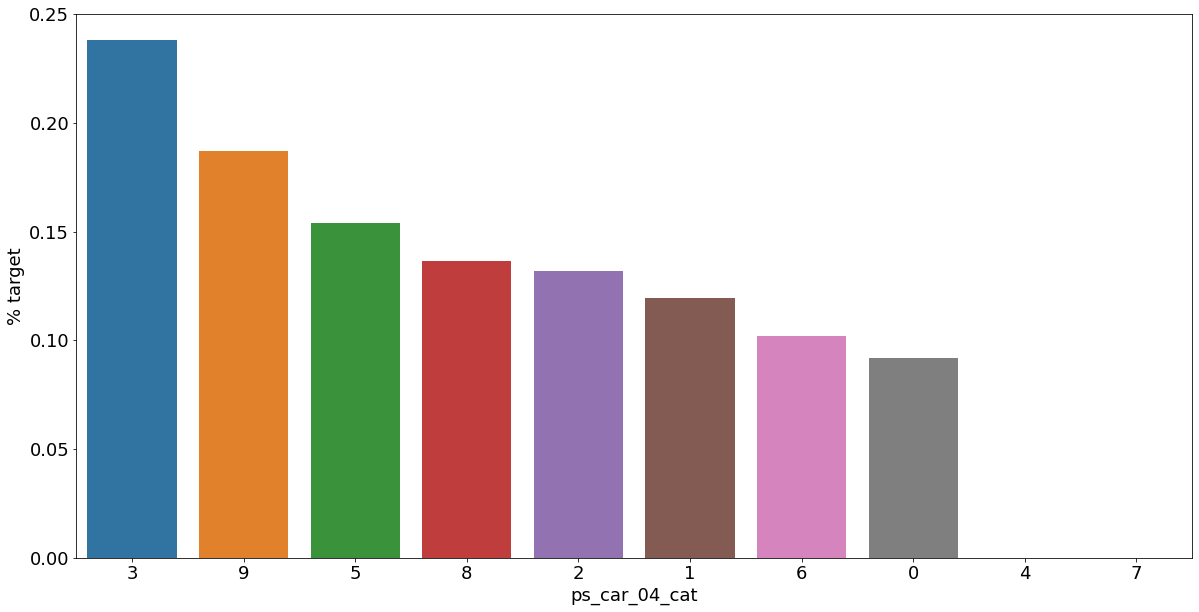

<Figure size 432x288 with 0 Axes>

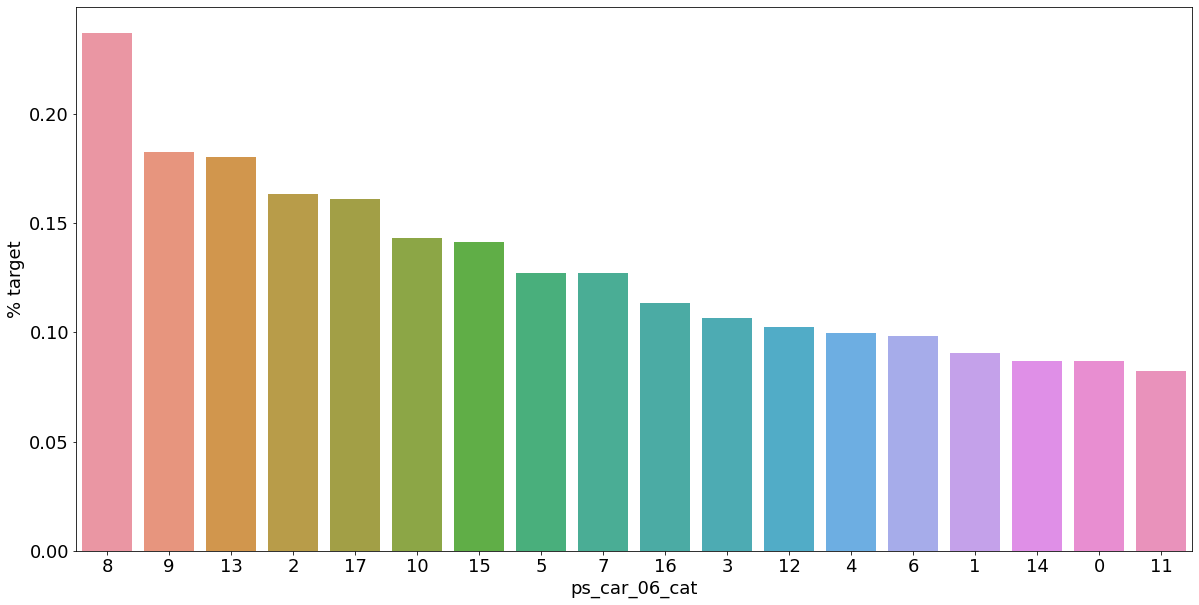

<Figure size 432x288 with 0 Axes>

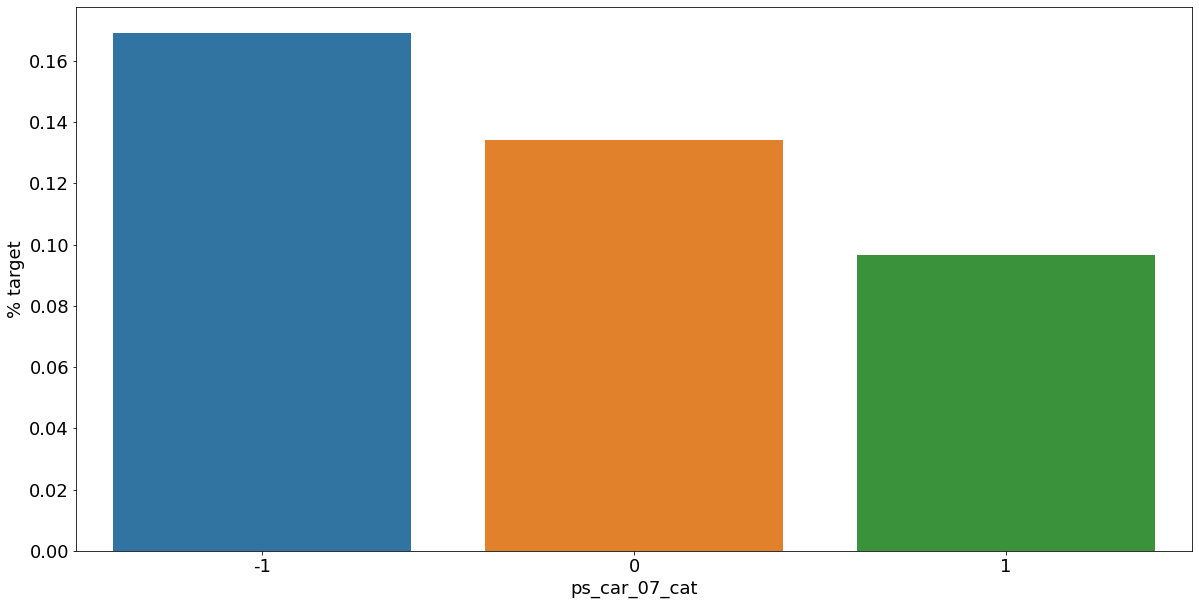

<Figure size 432x288 with 0 Axes>

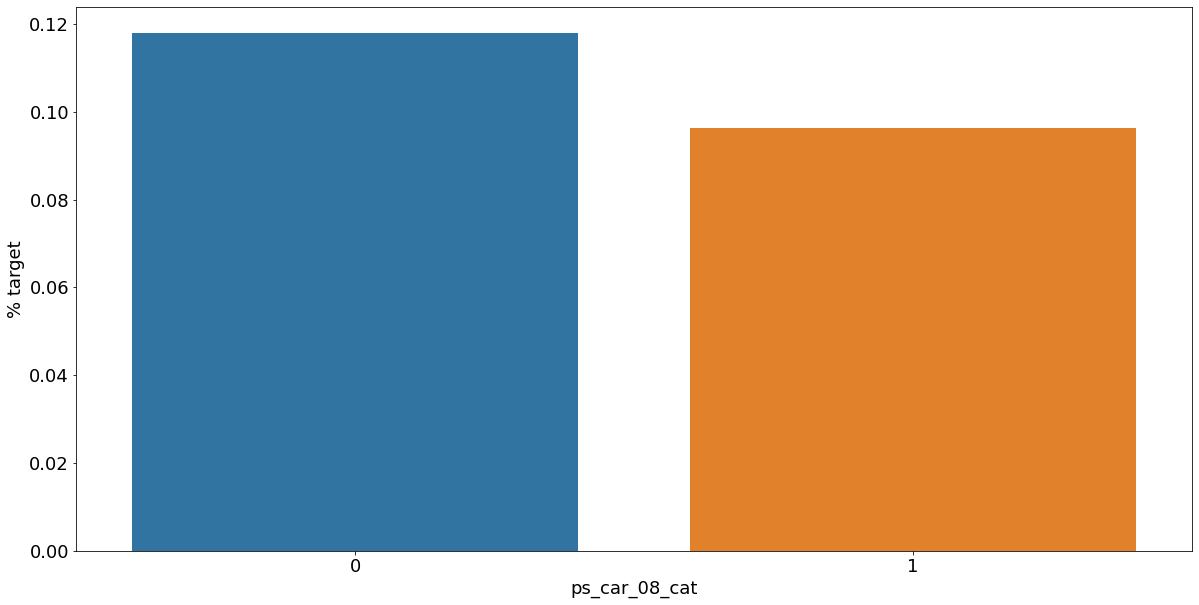

<Figure size 432x288 with 0 Axes>

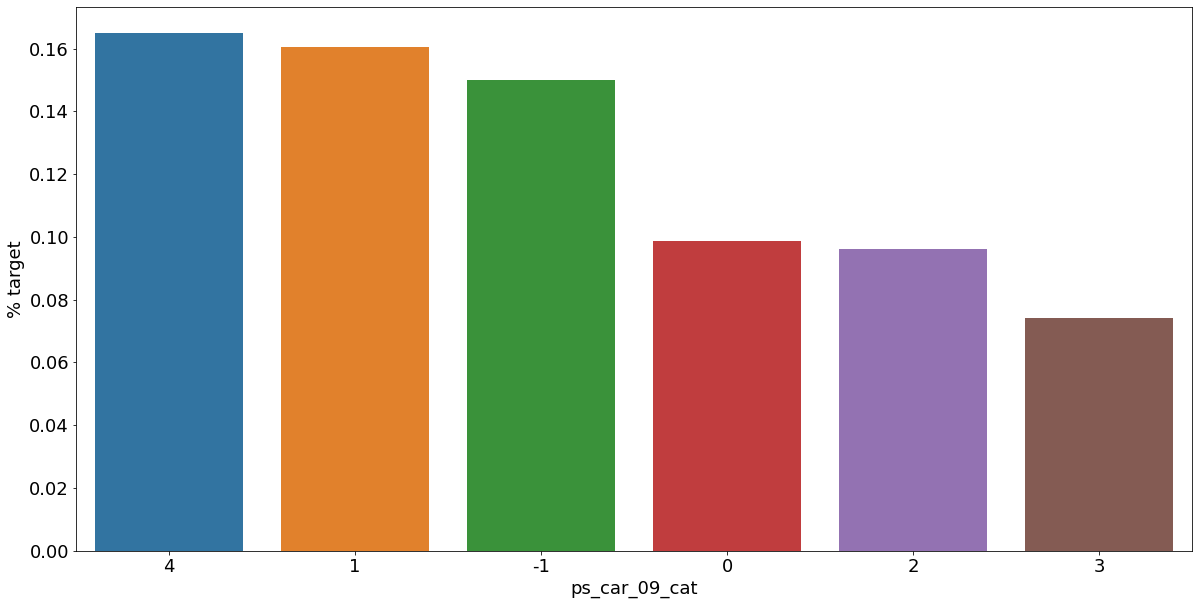

<Figure size 432x288 with 0 Axes>

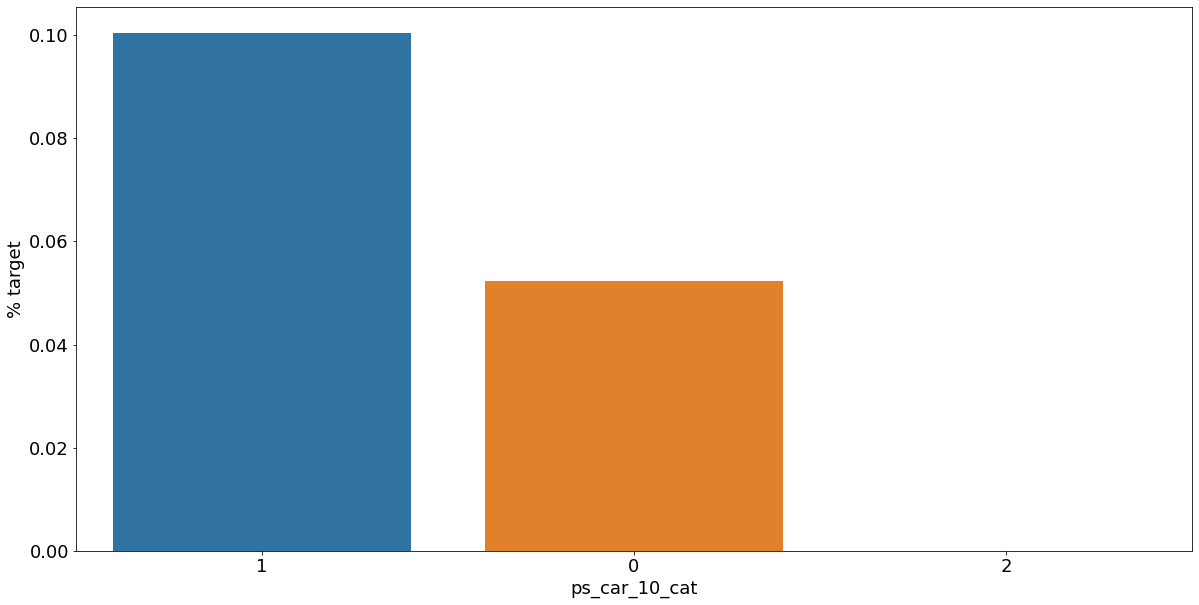

In [159]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

As we can see from the variables **with missing values**, it is a good idea to keep  
the missing values as a separate category value, instead of replacing them by the mode  
for instance. The customers with a missing value appear to have a much higher (in  
some cases much lower) probability to ask for an insurance claim.

**Interval variables**  
Checking the correlations between interval variables. A heatmap is a good way to  
visualize the correlation between variables. The code below is based on an example  
by Michael Waskom

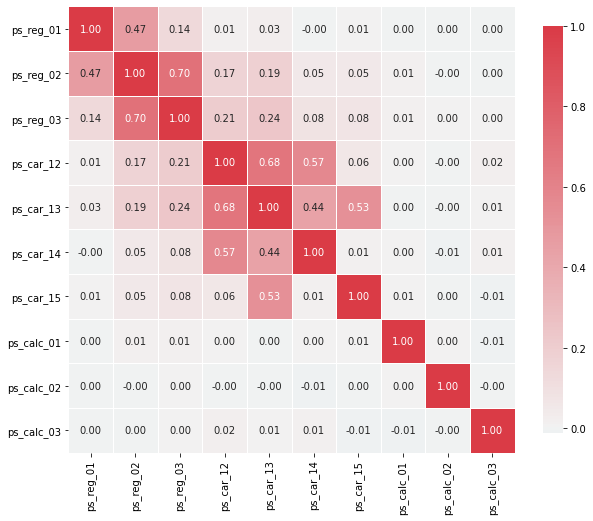

In [160]:
def corr_heatmap(v):
    correlations = train[v].corr()
    
    # Create color map ranging between two colors 
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, 
                annot=True, cbar_kws={"shrink": .75})
    plt.show();

v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

there are a strong correlations between the variables:  
* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car_13 (0.67)
* ps_car_12 and ps_car_14 (0.58)
* ps_car_13 and ps_car_15 (0.67)  
  
Seaborn has some handy plots to visualize the (linear) relationship between   
variables. We could use a pairplot to visualize the relationship between the variables.  
But because the heatmap already showed the limited number of correlated variables,  
we'll look at each of the highly correlated variables separately.  
**NOTE**: I take a sample of the train data to speed up the process. 

In [105]:
s = train.sample(frac=0.1)

**ps_reg_02 and ps_reg_03**  
As the regression line shows, there is a linear relationship between these variables.  
Thanks to the hue parameter we can see that the regression lines for target=0 and   
target=1 are the same.

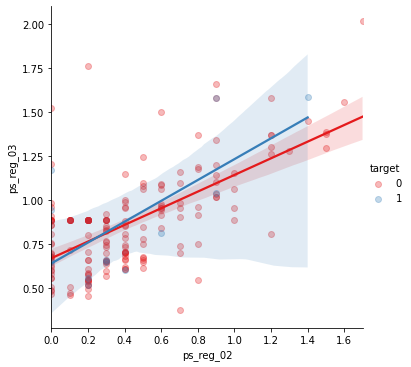

In [161]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_12 and ps_car_13**

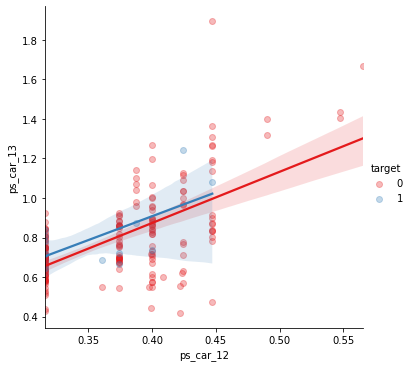

In [162]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_12 and ps_car_14**

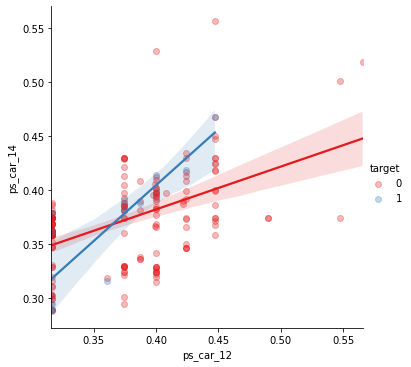

In [163]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_13 and ps_car_15**

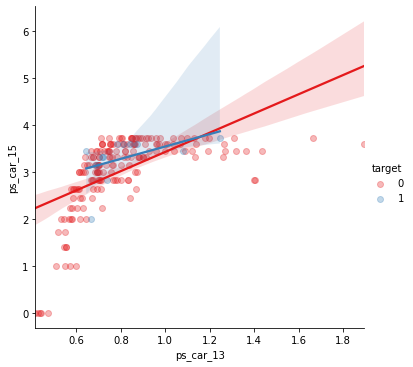

In [164]:
sns.lmplot(x='ps_car_13', y='ps_car_15', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep?  
We could perform Principal Component Analysis (PCA) on the variables to reduce the   
dimensions. In the AllState Claims Severity Competition I made this kernel to do that.  
But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

### Checking the correlations between ordinal variables

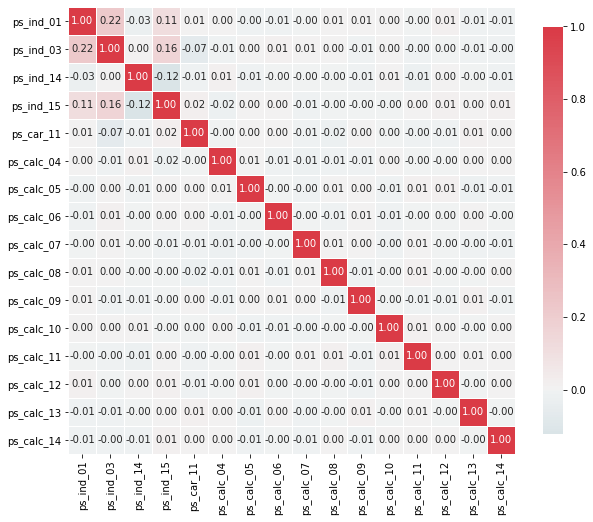

In [165]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

For the ordinal variables we do not see many correlations.   
We could, on the other hand, look at how the distributions are when grouping by the target value.

### Feature engineering

**Creating dummy variables**  
The values of the categorical variables do not represent any order or magnitude.  
For instance, category 2 is not twice the value of category 1. Therefore we can create  
dummy variables to deal with that. We drop the first dummy variable as this   
information can be derived from the other dummy variables generated for the   
cartegories of the original variable.

In [166]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))

train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 108 variables in train


So, creating dummy variables adds 52 variables to the training set.

### Creating interaction variables

In [167]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True) # Remove the original columns

# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 108 variables in train
After creating interactions we have 163 variables in train


This adds extra interaction variables to the train data. Thanks to the  
get_feature_names method we can assign column names to these new variables.

### Feature selection

**Removing features with low or zero variance**

Personally, I prefer to let the classifier algorithm chose which features to keep.  
But there is one thing that we can do ourselves. That is removing features with no or  
a very low variance. Sklearn has a handy method to do that: **VarianceThreshold**.

By default it removes features with zero variance.This will not be applicable for this  
competition as we saw there are no zero-variance variables in the previous steps.  
But if we would remove features with less than 1% variance, we would remove 31 variables.  

In [168]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance.  
But because we do not have so many variables, we'll let the classifier chose.  
For data sets with many more variables this could reduce the processing time.

Sklearn also comes with other feature selection methods. One of these methods is  
SelectFromModel in which you let another classifier select the best features and   
continue with these. Below I'll show you how to do that with a Random Forest.

### Selectiong features with a Random Forest and SelectFromModel

Here we'll base feature selection on the feature importances of a random forest.  
With Sklearn's SelectFromModel you can then specify how many variables you want to keep.  
You can set a threshold on the level of reature importance manually.  
But we'll simply select the top 50% best variables.

In [169]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.023225
 2) ps_car_12 ps_car_13            0.016519
 3) ps_reg_03 ps_car_13            0.016435
 4) ps_car_13                      0.016415
 5) ps_reg_03 ps_car_14            0.016396
 6) ps_car_13^2                    0.016310
 7) ps_car_13 ps_car_14            0.016250
 8) ps_car_13 ps_car_15            0.016158
 9) ps_reg_01 ps_car_13            0.016072
10) ps_reg_03 ps_car_12            0.015642
11) ps_car_14 ps_car_15            0.015329
12) ps_reg_03 ps_car_15            0.014587
13) ps_car_13 ps_calc_03           0.014498
14) ps_car_13 ps_calc_02           0.014483
15) ps_reg_01 ps_car_14            0.014371
16) ps_reg_03^2                    0.014310
17) ps_reg_03                      0.014263
18) ps_reg_01 ps_reg_03            0.013998
19) ps_car_13 ps_calc_01           0.013996
20) ps_reg_02 ps_car_13            0.013755
21) ps_car_12 ps_car_14            0.013720
22) ps_car_14 ps_calc_03           0.013591
23) ps_car_14 ps_calc_02        

With SelectFromModel we can specify which prefit classifier to use and what  
the threshold is for the feature importances. With the get_support method we can then  
limit the number of variables in the train data.

In [170]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))

n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))

selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 161
Number of features after selection: 81


In [171]:
train = train[selected_vars + ['target']]

## Feature Scaling

As mentioned before, we can apply standard scaling to the training data.  
Some classifiers perform better when this is done

In [172]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[ 0.55072486,  1.31195992,  1.60526103, ...,  1.2984163 ,
         1.37034402,  0.27885986],
       [-0.45563409,  2.42059881,  0.19298759, ...,  0.2602189 ,
         0.17616526, -0.46592581],
       [-0.45563409,  1.31195992,  1.32280634, ..., -0.74090001,
         0.3254376 ,  1.95462762],
       ...,
       [-0.95881357, -0.90531787, -0.0894671 , ..., -1.03752783,
        -0.71946882,  0.27885986],
       [ 1.5570838 ,  1.31195992, -0.0894671 , ..., -0.74090001,
        -0.12237944,  0.27885986],
       [ 1.5570838 ,  0.20332103,  1.60526103, ..., -1.07460631,
        -1.01801351, -1.02451506]])